# Decision Tree Analysis for Termite Data

In this Jupyter Notebook, we will explore how to use decision tree algorithms for both classification and regression tasks using a dataset that includes information about termite discovery and wood characteristics. We'll start by loading and cleaning the data, then preprocess it to fit decision tree models. Finally, we will visualize the trees to understand the decision-making process of the models.

## Load and Clean Data

First, we load the data from the CSV file and perform initial cleaning steps, which include converting date columns to a datetime format and calculating the duration of termite wood deployment. To prepare our data for the decision tree models, we handle missing values, encode categorical variables, and split the data into training and testing sets. This step is crucial for building robust machine learning models.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load and clean the data
data = pd.read_csv('../../global_termite_microbe_wd.csv')  # Adjust the path as needed

data['deployment_date'] = pd.to_datetime(data['deployment_date'])
data['harvest_date'] = pd.to_datetime(data['harvest_date'], format='%Y-%m-%dT%H:%M:%SZ')
data['deployment_duration'] = (data['harvest_date'] - data['deployment_date']).dt.days

# Drop rows with missing target values
data_cleaned = data.dropna(subset=['termite_discovery', 'final_wt'])

# Prepare column transformer for categorical encoding
categorical_cols = ['country', 'site', 'habitat_type', 'wood_used', 'wood_origin', 'treatment']
numerical_cols = ['latitude', 'longitude', 'N_pc', 'C_pc', 'P_pc', 'initial_wt', 'k_value', 'deployment_duration']

# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Split the data into features and target arrays
X = data_cleaned.drop(['termite_discovery', 'final_wt'], axis=1)
y_class = data_cleaned['termite_discovery']
y_regress = data_cleaned['final_wt']

# Split the data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_regress, X_test_regress, y_train_regress, y_test_regress = train_test_split(X, y_regress, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_class_prepared = preprocessor.fit_transform(X_train_class)
X_test_class_prepared = preprocessor.transform(X_test_class)
X_train_regress_prepared = preprocessor.fit_transform(X_train_regress)
X_test_regress_prepared = preprocessor.transform(X_test_regress)


## Building and Evaluating Models

We build and evaluate decision tree models for both classification (predicting termite discovery) and regression (predicting final wood weight). This step includes training the models and assessing their performance using common metrics.


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Building the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_class_prepared, y_train_class)

# Predicting on the training data
y_train_pred = dt_classifier.predict(X_train_class_prepared)

# Predicting on the test data
y_test_pred = dt_classifier.predict(X_test_class_prepared)

# Evaluating the model
print("Training Accuracy:", accuracy_score(y_train_class, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test_class, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test_class, y_test_pred))


Training Accuracy: 1.0
Testing Accuracy: 0.9063706563706564

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      1792
         1.0       0.66      0.65      0.65       280

    accuracy                           0.91      2072
   macro avg       0.80      0.80      0.80      2072
weighted avg       0.91      0.91      0.91      2072



In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Building the decision tree regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train_regress_prepared, y_train_regress)

# Predicting on the training data
y_train_pred_regress = dt_regressor.predict(X_train_regress_prepared)

# Predicting on the test data
y_test_pred_regress = dt_regressor.predict(X_test_regress_prepared)

# Evaluating the model
mse = mean_squared_error(y_test_regress, y_test_pred_regress)
print("Testing MSE:", mse)
print("Testing RMSE:", mse**0.5)
print("Testing R² Score:", r2_score(y_test_regress, y_test_pred_regress))


Testing MSE: 18.198729121138996
Testing RMSE: 4.265996849640069
Testing R² Score: 0.988107154508076


## Visualizing the Models

To better understand how our decision trees make classifications and predictions, we visualize their structures. This helps in interpreting the models and explaining their decisions.


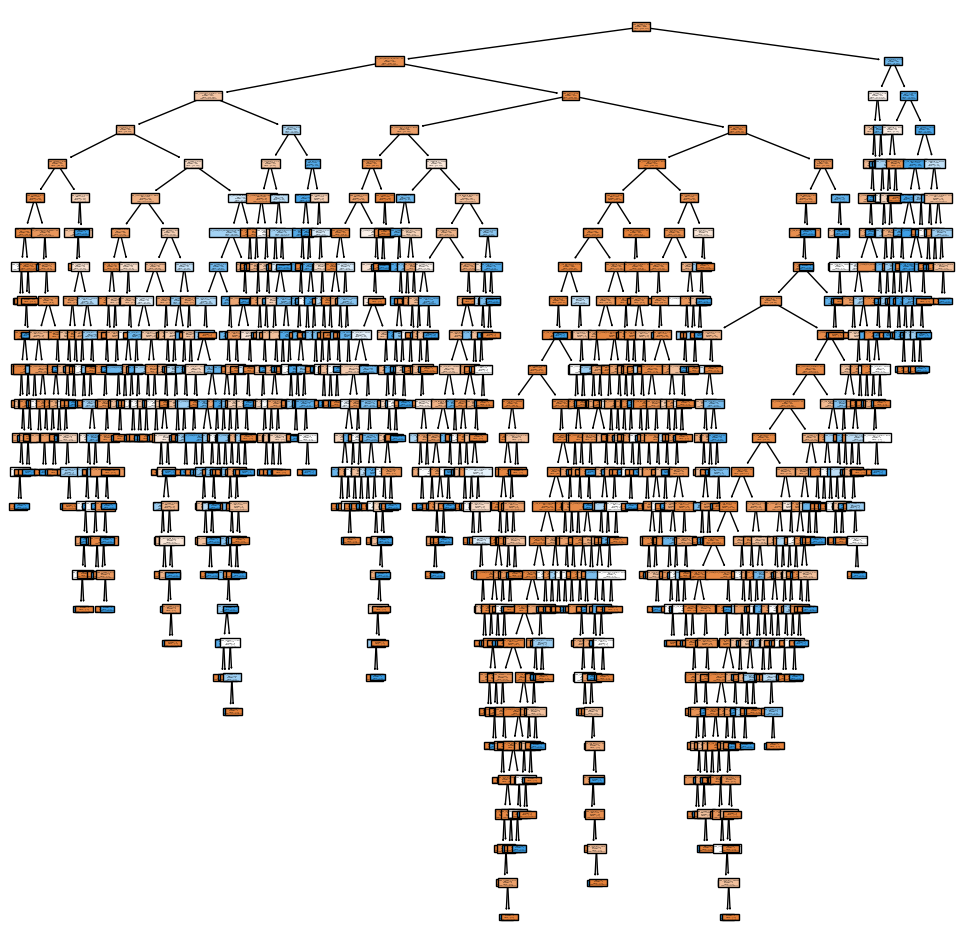

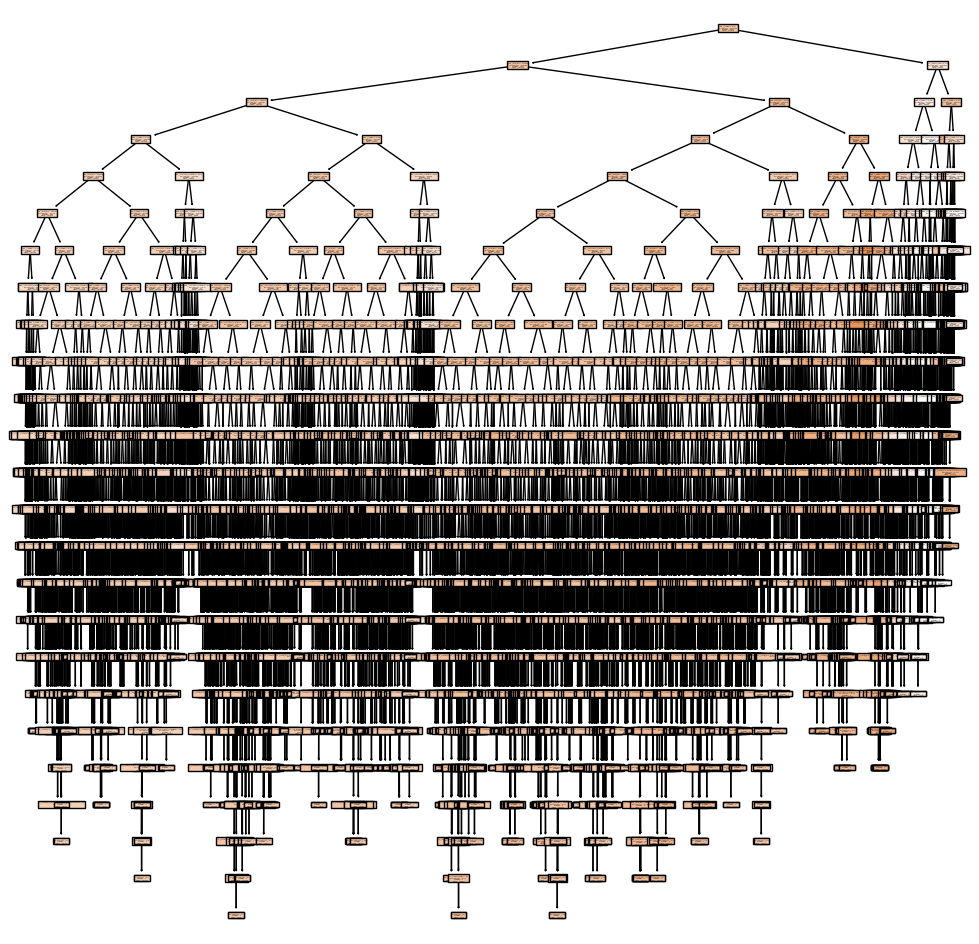

In [21]:
import matplotlib.pyplot as plt
from sklearn import tree

# Function to plot a decision tree
def plot_decision_tree(model, feature_names, class_names=None):
    fig, ax = plt.subplots(figsize=(12, 12))  # Set appropriate figure size
    tree.plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True, ax=ax)
    plt.show()

# Plotting the classifier
plot_decision_tree(dt_classifier, preprocessor.get_feature_names_out(), class_names=["Not Discovered", "Discovered"])

# Plotting the regressor (usually no class_names are needed here)
plot_decision_tree(dt_regressor, preprocessor.get_feature_names_out())


Decision trees are prone to overfitting. And although the model R^2 score is high which indicates high prediction accuracy, the trees are rather dense and may not generalize well.

## Simplifying the Decision Tree Model

Decision trees are powerful machine learning models that offer intuitive insights into how decisions are made. However, when a decision tree is too complex, it becomes difficult to interpret and may overfit the training data, which negatively affects its performance on unseen data. Overfitting occurs when a model learns not only the underlying patterns but also the noise in the training data, leading it to perform well on training data but poorly on new data.

### Why Simplify?

1. **Improve Interpretability**: Simpler trees are easier to understand and communicate to others. A tree that makes decisions based on a few key features is more comprehensible than one that splits on many features, especially for non-technical stakeholders.
2. **Reduce Overfitting**: By limiting the depth of the tree and the complexity of decisions, we reduce the risk of the model learning noise and fine details from the training data that do not generalize to new data.
3. **Enhance Generalization**: A simpler model may have lower accuracy on training data but can often perform better on testing data by capturing the most significant patterns.

### How to Simplify?

To control the complexity of a decision tree, we can adjust several parameters:
- **`max_depth`**: Limits the maximum number of levels in the tree. A lower depth makes the tree broader and less deep, thus simpler.
- **`min_samples_split`**: Sets the minimum number of samples a node must have before it can split. Higher values prevent the model from learning overly specific patterns.
- **`min_samples_leaf`**: Specifies the minimum number of samples a leaf node must have. This ensures that the tree does not create leaves with very few samples, which might represent outliers or noise.

### Implementing a Simpler Model

Below, we train a simpler decision tree classifier using these constraints and compare its performance with the more complex model. We also visualize the simplified tree to assess its interpretability.


Testing Accuracy: 0.9116795366795367

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      1792
         1.0       0.79      0.47      0.59       280

    accuracy                           0.91      2072
   macro avg       0.86      0.72      0.77      2072
weighted avg       0.90      0.91      0.90      2072



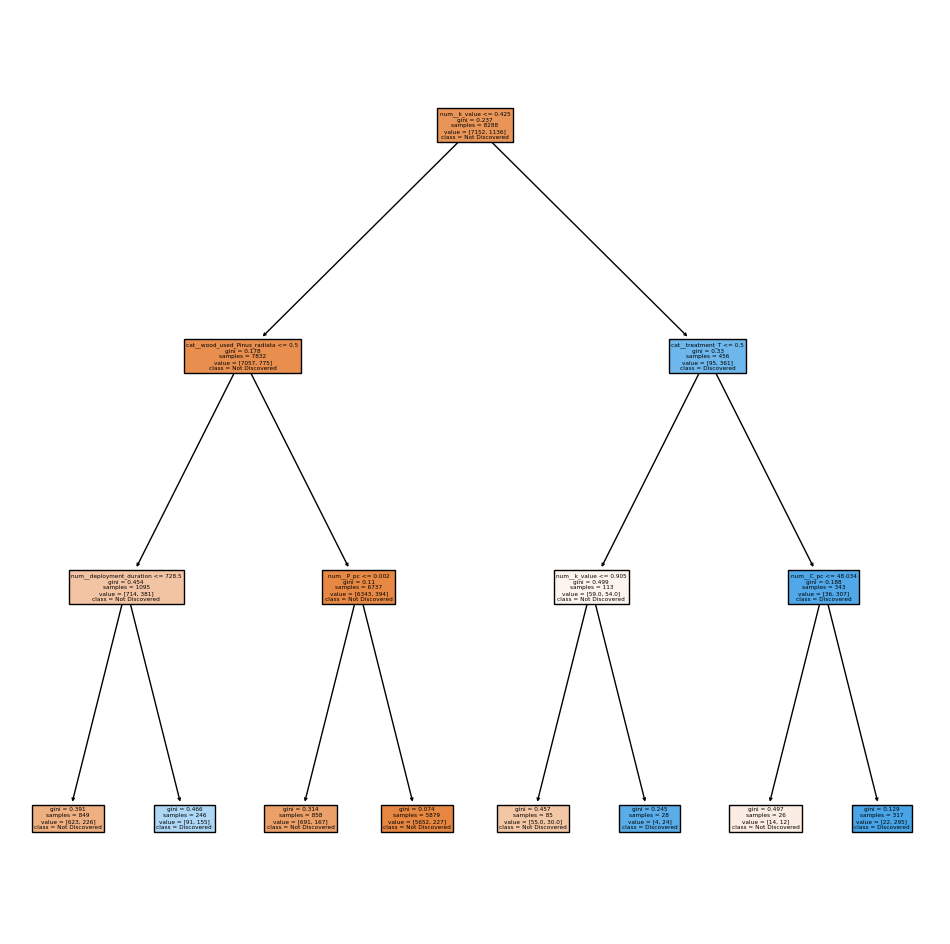

In [22]:
# Decision Tree with controlled complexity
dt_classifier_simple = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
dt_classifier_simple.fit(X_train_class_prepared, y_train_class)

# Evaluating the simpler model
y_test_pred_simple = dt_classifier_simple.predict(X_test_class_prepared)
print("Testing Accuracy:", accuracy_score(y_test_class, y_test_pred_simple))
print("\nClassification Report:\n", classification_report(y_test_class, y_test_pred_simple))

# Visualizing the simpler decision tree
plot_decision_tree(dt_classifier_simple, preprocessor.get_feature_names_out(), class_names=["Not Discovered", "Discovered"])

## Conclusion

This notebook provided a comprehensive guide on how to apply decision tree algorithms to real-world data. Through classification and regression models, we've seen how decision trees help in making predictions and the factors that influence their performance. Additionally, we looked at the trade-off between accuracy and generalizability.Understanding these models allows for more informed decisions in data-driven projects.
